<a href="https://colab.research.google.com/github/NatasaKinzy/Data-Science/blob/main/Unit3/Unit3NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz[full,notebook]"

In [ ]:
import preliz as pz

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

#Unit 3: Making and Modifying Models

We will:

- Practice Selecting Priors
- Practice Selecting Likelihoods, using posterior predictive checks
- Begin to focus on matching reality, instead of matching data


##Selecting Priors

There are three types of priors:
- Informative priors, defined as priors that "strongly" direct our model. These are often devised using our knowldge about the context in question.
- Uninformative priors, defined as priors that make the least amount of assuptions as possible. [Uninformative means different things in different contexts.](https://stats.stackexchange.com/questions/20520/what-is-an-uninformative-prior-can-we-ever-have-one-with-truly-no-information?newreg=acc7fa13b7cf4e72bcdbeaec65d6b586)
- Nonsensical priors, AKA "bad" priors. These are priors that in some way contradict what's known about the context or contradict our likelihood.

Let's start with some sensical priors, both informative and uninformative.

### Resonable priors, and their differences

Recall the Victor Wembanyama FT example from last unit. I chose that example because there's a very intuitive choice for a prior, specifically Wembanyama's FT shooting in Euroleague play.

However, we didn't have to base our prior on his prior FT shooting. We could have arbitraily chosen a distribution that "felt right" to us. As long as we don't contradict reality or our likelihood, things will be fine.



Let's do some examples:

In [ ]:
#Wemby's FTs from his first 2 NBA games
FT_data = np.repeat([1,0], repeats = [7,2])

In [ ]:
#same model from before, but named wmbyE_FT_model, where to E is for Euroleauge

with pm.Model() as wmbyE_FT_model:
  #we define our prior with the makes and misses from Euroleague
  θ = pm.Beta('θ' , alpha = 24. , beta = 8.)

  #The Bernoulli likelihood is a stand in for the binomial distribution
  y = pm.Bernoulli('y', p = θ, observed = FT_data)

  #sample from our posterior
  idata_FT_E = pm.sample(2000)

Output()

<Axes: title={'center': 'θ'}>

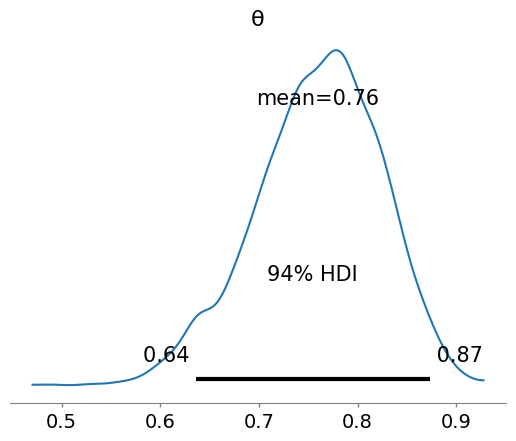

In [ ]:
#vizualize the 2000 samples from the pymc model of the posterior
az.plot_posterior(idata_FT_E)

**Task1**:

Make a new model wmbyU_FT_model, where the prior is a uniform distribution, but everything is otherwise the same.

In [ ]:
#ANSWER1
#same model from before, but named wmbyU_FT_model, where to U is for Uniform

with pm.Model() as wmbyU_FT_model:
  #all possible FT proportions are equally possible
  θ = pm.Uniform('θ',lower=0,upper=1)

  #same as before (likelihood)
  y = pm.Bernoulli('y', p = θ, observed = FT_data)

  #sample from our posterior
  idata_FT_U = pm.sample(2000)

Output()

**Task2**:

Ask least one other person about possible similarities and differences between the posterior's of wmbyE_FT_model and wmbyU_FT_model. Then, write down what you both said.

**Answer2**:

Me: The eurolegue model uses previous data about Wenbanyama's free throws while the uniform distribution model assumes all possibilities are equally likely. Both are posteriors but are based on completely different assumptions.

Other person: mean of uniform prior is smaller (dragged towards mean of 0.5).

The data in the uniform prior is also much more broad (larger range) than the beta data.



**Task3**:

Describe the differences in how we'd interpret wmbyE_FT_model versus wmbyU_FT_model. How would using one instead of the other change our predictions?

**Answer3**:

Euroleague: more precise estimate, informative prior: reasonable direction for data to trend - based on past information

Uniform: highly varried and imprecise model, very poor understanding of context, uninformative prior


### Nonsensical Priors

We've now seen that our choice of prior can meaningfully change our model and predictions, at least for this small data set of 9 FT attempts.

And that was with priors that made sense. Let's see what happens when we use a prior that doesn't make sense.

I'm going to do several things wrong.

- My prior will be centered around 0.1 .
- I'll use a normal dsitribution.
- 78% of the probability of my prior will be between 0 and 0.2 .

Here's what the prior looks like:

(Normal(mu=0.1, sigma=0.0815), <Axes: >)

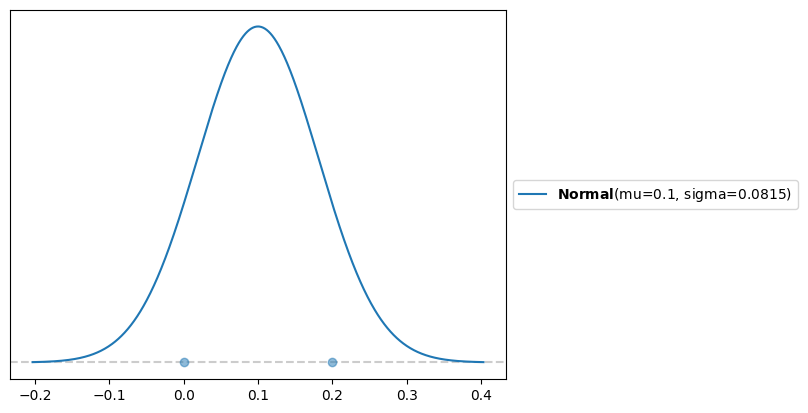

In [ ]:
#Finds the maximum entropy distrbution with the restriction that 0.78 of its
#mass is between 0 and 0.2

pz.maxent(pz.Normal(), lower = 0, upper = 0.2, mass = 0.78)

**Task4**:

All the assumptions I made in making the prior are "bad", in this context.

Explain why.

**Answer4**:

- 0.1 would be a horrible FT% for an NBA player so that's super innacurate
- normal distribution allows for any real number but we are looking for positive fractions between 0 and 1.
- this prior gives an 11% chance of getting a negative value which is way too high for getting an impossible value.

Now that we know why a $Normal(μ=0.1,σ=0.08)$ prior is unreasonable, let's see what happens when we use it.

In [ ]:
#same model from before, but named wmbyN_FT_model,
#where to N is for normal

with pm.Model() as wmbyN_FT_model:
  #our nonsensical prior
  θ = pm.Normal('θ', mu=0.1,sigma=0.08)

  y = pm.Bernoulli('y', p = θ, observed = FT_data)

  idata_FT_N = pm.sample(2000)

Output()

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


pymc has given us an indication that we did something wrong. At the right most end of output text it says "divergences".

Remember how I told you to think of the engine that powers are model like a car? If our model has more than 0 divergences, consider one of the warning lights on.

Divergences can mean anything from "proceed with caution" to "throw your model in the trash an burn it". In this case, we don't need to be experts in Markov Chain managment to diagnose what's wrong: its that 11% chance of a negative FT% that's causing all the confusion.

Despite being suspect, our model still ran, and it produced the following posterior:

<Axes: title={'center': 'θ'}>

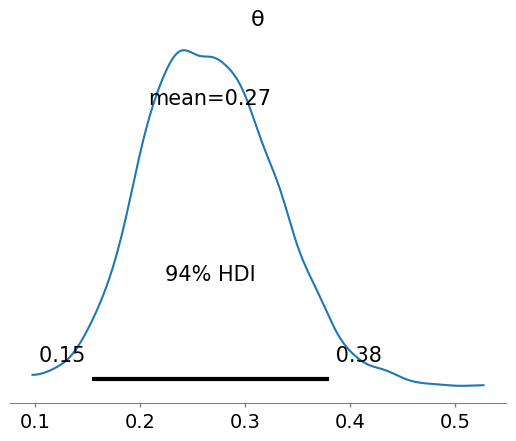

In [ ]:
az.plot_posterior(idata_FT_N)

**Task5**:

Is there anything about the posterior distribution that tells you that the model is poor enough that we shouldn't trust its predictions?

**Answer5**:

Nope - no divergences = good for now


**Task6**:

What happens if we made our prior even more nonsensical? What would be an example of that?

**Answer6**:

Often the model wont run or it will only run once more. This is often problematic, sometimes useful, and always interesting.

Divergences don't always mean something is horribly wrong but it does usually mean that you could make your model better.

If you're getting divergences, you likely need to redesign some part of your model.


### Data Dominates Priors

While nonsensical priors can ruin a model, as long as we state a prior that only gives values in our event space--from 0 to 1 in the FT example--then things will work out.

To see why, let's rerun all three models: the informative beta prior model, the uninformative uniform prior model, and the nonsensical normal prior model.

In [ ]:
#Wemby's FTs in the 2023/2024 season, makes then misses
FT_data_2324 = np.repeat([1,0], repeats = [292,75])

In [ ]:
#2023/2024 wmbyE_FT_model, where to E is for Euroleauge

with pm.Model() as wmbyE_FT_model:
  #we define our prior with the makes and misses from Euroleague
  θ = pm.Beta('θ' , alpha = 24. , beta = 8.)

  #The Bernoulli likelihood is a stand in for the binomial distribution
  y = pm.Bernoulli('y', p = θ, observed = FT_data_2324)

  #sample from our posterior
  idata_FT_E2324 = pm.sample(2000)

Output()

<Axes: title={'center': 'θ'}>

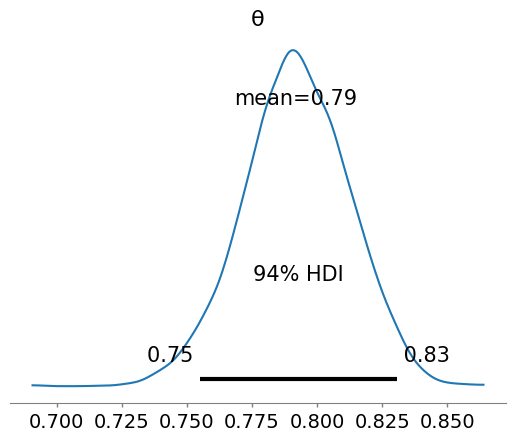

In [ ]:
az.plot_posterior(idata_FT_E2324)

In [ ]:
#2023/2024 wmbyU_FT_model, where to U is for Uniform

with pm.Model() as wmbyU_FT_model:
  #we define our prior with the makes and misses from Euroleague
  θ = pm.Uniform('θ' , lower = 0 , upper = 1)

  #The Bernoulli likelihood is a stand in for the binomial distribution
  y = pm.Bernoulli('y', p = θ, observed = FT_data_2324)

  #sample from our posterior
  idata_FT_U2324 = pm.sample(2000)

Output()

<Axes: title={'center': 'θ'}>

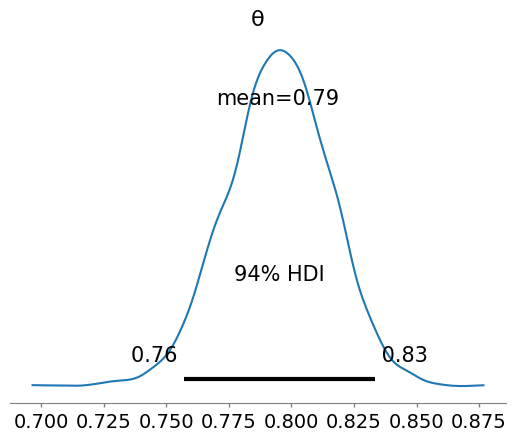

In [ ]:
az.plot_posterior(idata_FT_U2324)

**Task7**:

Describe similarities and differences between the posteriors of wmbyE_FT_model and wmbyU_FT_model. Give an explanation for these similarities and differences.

**Answer7**:

Similarities:

*   means are exact same
*   ranges are super similar
*   no divergences for either

Differences:

*   step size is larger in Uniform model in the first set of draws and SUBSTANTIALLY larger in the second set of draws as compared to the Euroleague model

There are no discernable differences, at least to my eyes.

This is because all posteriors with the same likelihood will converge to the same distribution--as long as the priors are sensible--as we get more data.

This is great news! It means we are free to choose a prior that makes our heart sing, knowing that it won't keep us from learning the truth, if evidence contradicts our assumption. Note that this effect even extends to many nonsensical priors; see the next example.

In [ ]:
#2023/2024 wmbyN_FT_model, where to N is for Normal

with pm.Model() as wmbyN_FT_model:
  #we define our prior with the makes and misses from Euroleague
  θ = pm.Normal('θ' , mu = 0.1 , sigma = 0.08)

  #The Bernoulli likelihood is a stand in for the binomial distribution
  y = pm.Bernoulli('y', p = θ, observed = FT_data_2324)

  #sample from our posterior
  idata_FT_N2324 = pm.sample(2000)

In [ ]:
az.plot_posterior(idata_FT_N2324)

**Task8**:

Describe similarities and differences between the posterior of wmbyN_FT_model and the other two posteriors, wmbyE_FT_model and wmbyU_FT_model. Give an explanation for these similarities and differences.

**Answer8**:



wmbyN_FT_model has the same length HDI and shape, but it's centered a little lower, at 0.74 instead of 0.79.

This may seem like a big difference, but remember, for the normal prior model, we started with the assumption that Wemby was a 10% FT shooter. That estimate has shifted all the way up to 74%. The data is winning out over our assumption, even though our assumption is very wrong and very strong.

Hopefully you also noticed that there were no divergences--this is good, but it doesn't absolve our choice of prior. You can think of it this way--the amount of data "hid" how poor our choice of a prior was.

This may make it seem like priors don't matter for large data sets, and that's somewhat true; for simple models, uninformative, or lightly informative priors are all we'll need. The rest is usually overkill.

But for the complex models found later in the course, priors will make a big comeback utility.

For now though, let's switch to the other big choice we make in desgining a model.

## Selecting Likelihoods

So if priors aren't the most powerful part of our model, what is?

The likelihood!



Take the FT. We didn't directly conceptualize Wemby's FTs as a binomial distribution. We ended up modeling each free throw using a bernoulli distribution, which lacks information about the number of attempts. This works out because the number of attempts is included in the data. You saw this in the output of the our predictions in Unit 2.

Our choice of likelhood depended on the structure of our data, our context, and the question we're trying to answer.

Let's see this in action with a new context, and new set of data.

First, we need to download the data to this colab notebook. I'll also take a moment to introducce the data set.

Nuclear magnetic resonance (NMR) produces values known as chemical shifts, which is defined as the difference between the resonant frequency of spinning protons and a reference molecule. These chemical shifts are used to identify properties of various compounds, often in organic chemistry and related fields.

We'll use this data for three reasons:
- To show you that the techniques in this class apply to all things, from NBA FT shooting to quantum chemistry applications.
- Its a great illustrative example for both likelihoods and heirarchical models (next unit) that our textbook has already set up.
- Its cool as heck.

In [ ]:
#load the data from my github page. Works as long as you have an internet
#which you should if you're using colab.
url_chemshift = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts.csv'
#I could have put the url string directly into pd.read_csv()
data_chemshift = pd.read_csv(url_chemshift)

In [ ]:
#view raw data
#I did this, colab offered to plot it for me, which is wonderful
#I'd already made a histogram (shown in the next code block), but its a rad feature.
#There appear to be other features--use them, they seem neat!
data_chemshift

,51.06
0,55.12
1,53.73
2,50.24
3,52.05
4,56.40
5,48.45
6,52.34
7,55.65
8,51.49
9,51.86


(array([ 3., 11., 17.,  9.,  5.,  0.,  0.,  1.,  0.,  1.]),
 array([47.72 , 49.806, 51.892, 53.978, 56.064, 58.15 , 60.236, 62.322,
        64.408, 66.494, 68.58 ]),
 <BarContainer object of 10 artists>)

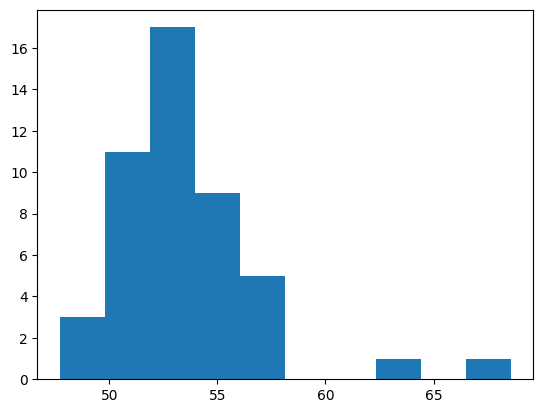

In [ ]:
# Now I visualize the raw data as a histogram with 10 bins (the default)
plt.hist(data_chemshift)

**Task9**:

Describe the histogram. Be as detailed as possible.

**Answer9**:

Data is centered around 53 with 2 outliers in the 60s. This is called data skewed right.

We want to make a model that captures pattern(s) in our data. How many of the patterns? We'll spend the rest of the course disscussing how to capture more patterns, and whether or not we should.

For right now, let's assume we want to capture all the patterns, but we don't know how.

From our raw data and histogram, its clear that we should't use a bernoulli likelihood; our data isn't limited to just 0 or 1. In fact, its not even discrete, as these chemical shift values look like that can take on any positive real number.

We've just seen a distribution that covers all real numbers--the Normal distribution!

The normal distribution is a good pick as a likelihood if two things are true:
- our data apears to come from the real numbers
- the only context we have is that our data varies symmetrically around a value.

The first contraint is true, but the second is a little dubious. Let's run a model with this likelihood assumption anyway, and then make it better later.

Why just shove a normal distribution in to get the model running? Because we still need to think about our priors. That's right, two priors: one for the expected value our data varies around, and a second one for how much the data varies around that mean.

The following are graphs of the priors I'll use.

<Axes: >

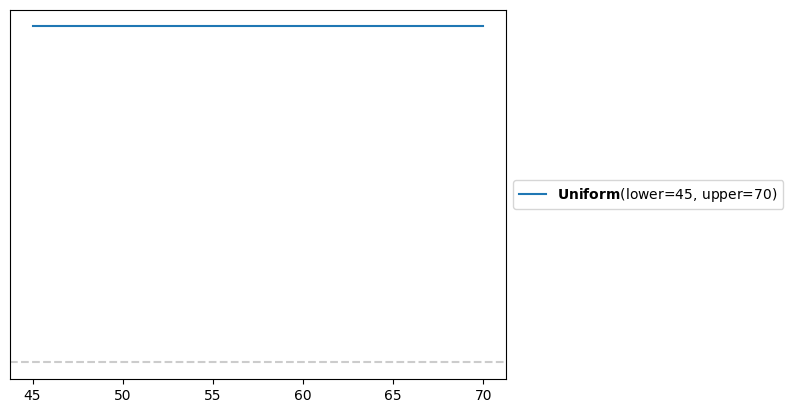

In [18]:
#unifrom prior, because I don't understand this context at all
# 45 is a little lower than the smallest chemical shift,
# 70 is a little higher than the largest chemical shift.
pz.Uniform(45,70).plot_pdf()

I'll use a new distribution for the prior of my standard deviation.

Why half a normal distribution? Because the half normal:
- only contains the positive reals, and our standard deviation (the parameter for variation) from the center is always positive.
- it has most of its weight towards small values of the reals; this prevents our model from having to test massive values for our variation.

<Axes: >

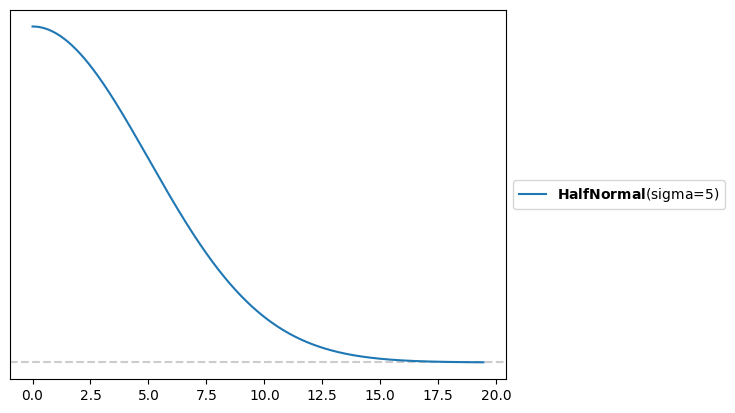

In [19]:
# why sigma = 5? B/c our textbook used it, and it seems to work well
pz.HalfNormal(sigma = 5).plot_pdf()

Here's the full model.

In [20]:
#N for normal
with pm.Model() as model_chemshiftN:
    # I have no idea where the mean should be, but its reasonalbe to assume
    # its between our lowest and highest values recorded
    μ = pm.Uniform('μ', lower=45, upper=70)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=5)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_chemshift)
    idata_chemshiftN = pm.sample()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

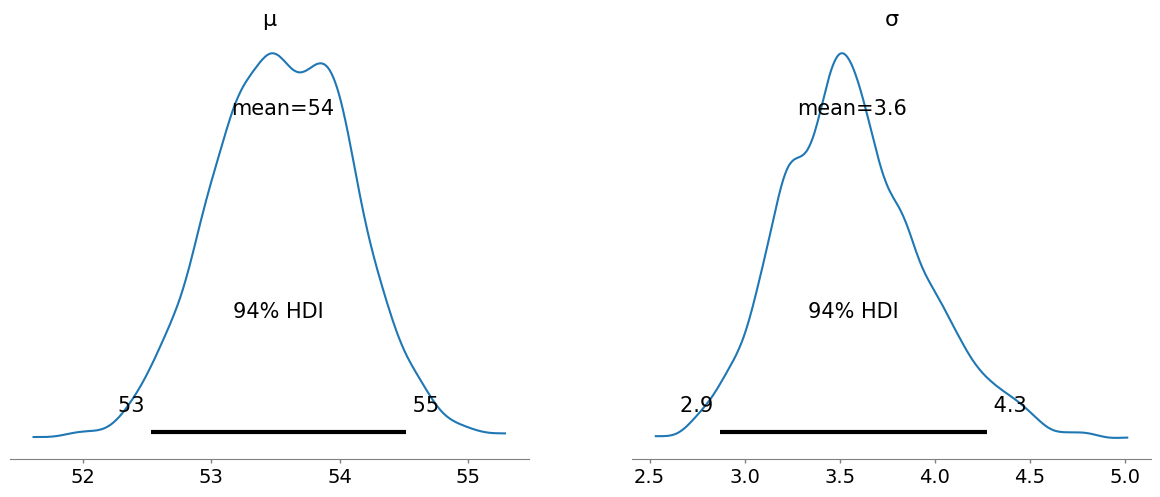

In [21]:
az.plot_posterior(idata_chemshiftN)

Our posterior is actually  two dimensional now, since we have two priors. If you want to see which pairs of $μ$ and $σ$ our model recommends, you can use the code below.

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

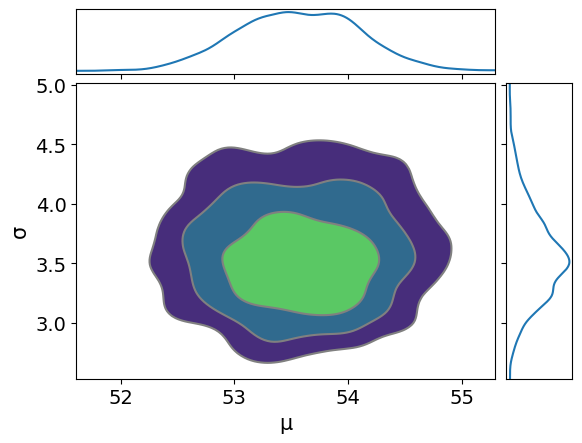

In [22]:
#The following code block is taken directly from the textbook BAP3.

az.plot_pair(idata_chemshiftN, kind='kde', marginals=True)

The actual graph of the posterior will take up less of our attention as we move through this course; we often only care about the posterior because we use it to make predictions.

To that end, we'll use posterior predictive checks (ppc).

In [23]:
pm.sample_posterior_predictive(idata_chemshiftN, model=model_chemshiftN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

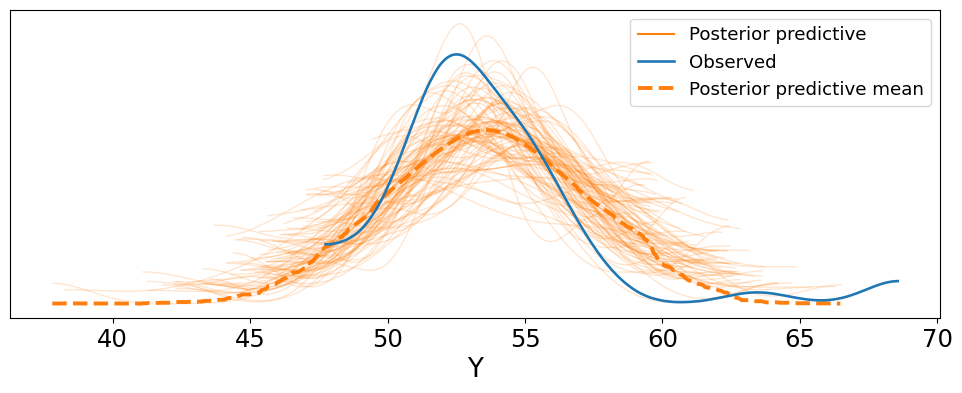

In [24]:
#The following code block is taken directly from the textbook BAP3.
#Plots the posterior predictive density overlaid with a smoothed version of the data

az.plot_ppc(idata_chemshiftN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Task10**:

Using the graph above, answer the following questions:

1. Does model_chemshiftN model the chemshift data well?
2. How confident should we be in those predictions?

**Answer10**:

To quote Osvaldo Martin, author of the textbook we're using for this course, "Based on my experience with this kind of measurment, I would say this model is a reasonable enough representation of the data and a useful one for most of my analysis." He then starts to talk about how to make it better. In summary, its fine, but we can do better. And we will.

Again, this is sort of a wobbly thumbs up. All those thin orange lines are actual guesses our model made; the dashed line is the mean of those guesses. If those thin lines where closer to the dashed line, we could be more confident about our predictions. There are two ways to do that: gather more data, or apply addition model structure.

###Normality

One way to make our predictions better is to change how we handle outliers--those two values that are away from the rest of the distribution. We can do this by picking a dist that's "flatter"--one that expects to see more outliers.

Comments on notation: $ν$ is pronouced "nu". You may also call $ν$ our normaility parameter.  A higher $ν$ means more normal.

In [ ]:
#The following code block is taken from the textbook BAP3, with comments added.
#Focus only on the output.

#plot four T dists, with four different normality parameters
for nu in [1, 2, 10, 30]:
    #all have mean 0 and standard deviation 1
    pz.StudentT(nu, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4))

#T dist with normality parameter of infinity
ax = pz.StudentT(np.inf, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4), color="k")

#make one of the dist have a dashed lin
ax.get_lines()[-1].set_linestyle("--")
#provides legend to read the graph better.\
pz.internal.plot_helper.side_legend(ax)

**Task11**:

For what value of $ν$ does the T dist become the normal dist?

**Answer11**:

***v*** = infinity

nu = 30 is rly close (the curves are hard to distinguish) so it's normal enough

We'll need a prior for $ν$, and I'll choose the following.

<Axes: >

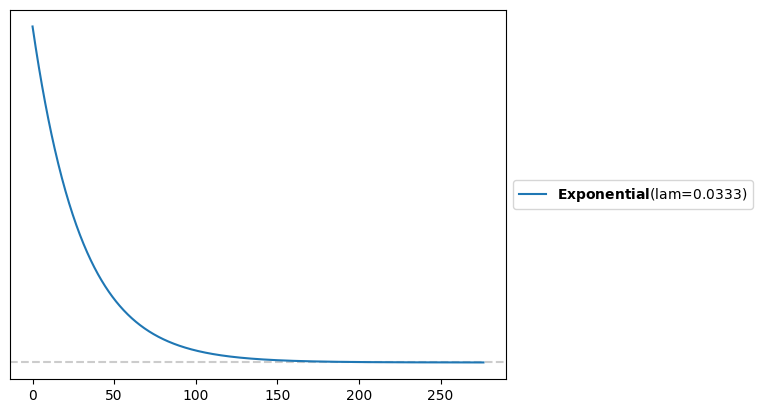

In [26]:
pz.Exponential(lam = 1/30).plot_pdf()

**Task12**:

Why is this a good choice of prior for $ν$?

**Answer12**:

With this prior, we are far more likely to pick smaller values of
***v***, which allows our model to be less normal. The expected value is still 30 though, which means we still expect our distribution to be approximately normal.

Once you understand $ν$ and its prior, run the next model with the Student T likelihood.

In [27]:
#T is for Student's T distribution
with pm.Model() as model_chemshiftT:
    # weak prior
    μ = pm.Uniform('μ', lower=45, upper=70)

    #the same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #this is our normality parameter; lam = 1/30 gives a mean of 30
    ν = pm.Exponential('ν', lam = 1/30)

    #new likelihood, same data
    y = pm.StudentT('y', mu=μ, sigma=σ, nu = ν, observed=data_chemshift)
    idata_chemshiftT = pm.sample()

Output()

In [28]:
pm.sample_posterior_predictive(idata_chemshiftT, model=model_chemshiftT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(40.0, 70.0)

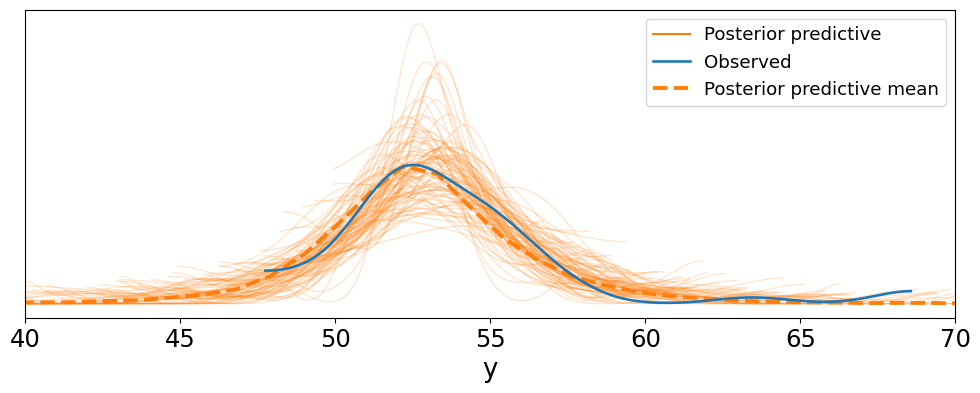

In [29]:
#The following code block is taken from the textbook BAP3.
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_chemshiftT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(40, 70)

**Task13**:

Using the graph above, answer the following questions:

1. Does model_chemshiftT model the chemshift data well?
2. How confident should we be in those predictions?

**Answer13**:
1. Very well - the only issue is that the distribution extends really far into the negatives (so much so it had to be limited)
2. Same amount of confidence - the context of the outliers is still unknown and the prediction is just as unclear as before


###Matching Reality, Not the Data

We don't always want our model to perfectly match the data--we want our model to match reality.

I'll show you one more model with the chemshift data to get you thinking about the assumptions we make when we select a likelihood.


**Task14**:

What assumption did we make about the outliers when we selected the T distribution as our likelihood in model-chemshiftT?

**Answer14**:

We assumed outliers were just as likely both above and below the mean. We assumed distrbution was symmetric even though the data wasn't.

This was fine because we didn't know the context.


If we think that there is a consistent low chance of observing values much higher than average, then we think our distribution has skew. We can model this with a SkewNormal disttribution; see the following example.

In [30]:
#SN is for skew normal
with pm.Model() as model_chemshiftSN:
    #same weak prior
    μ = pm.Uniform('μ', lower=45, upper=70)

    #same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #This gives our model the ability to skew towards either the positive numbers
    #or towards the negative numbers
    α = pm.Exponential('α', lam = 1/2)

    #SkewNormal, which is the same as a normal, except with more unusually high
    #or unusually low values.
    y = pm.SkewNormal('y', mu=μ, sigma=σ, alpha = α, observed=data_chemshift)
    idata_chemshiftSN = pm.sample()

Output()

In [31]:
pm.sample_posterior_predictive(idata_chemshiftSN, model=model_chemshiftSN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

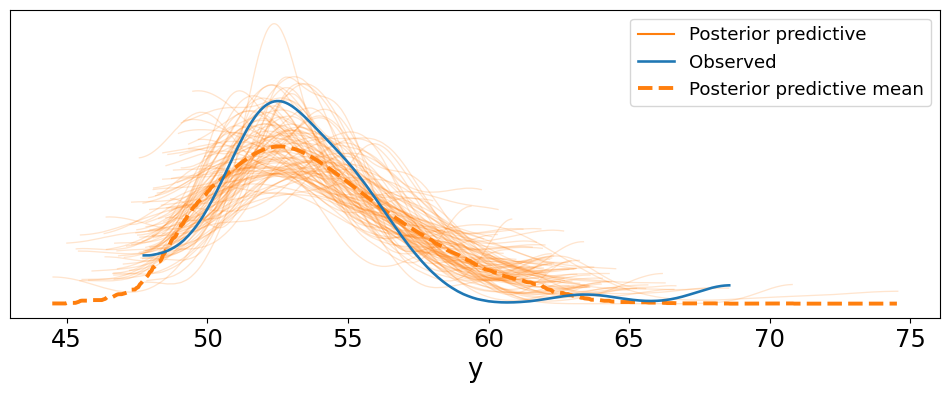

In [32]:
az.plot_ppc(idata_chemshiftSN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Task15**:

Using the graph above, answer the following questions:

1. Does model_chemshiftSN model the chemshift data well? Better than model_chemshiftT?
2. How confident should we be in those predictions?


**Answer15**:
1. It is a better model if we assume there are only outliers in the positive direction. If we assume there are outliers in negative direction as well, T model is better. We want model to closely resemble the process that generated our data used.
2. Same as before; still poor understanding of context and same amount of variation.


Is there a SkewStudentT distribution? Yes! Here it is, in all its glory.

In [ ]:
#ST is for skew T
with pm.Model() as model_chemshiftST:
    #same weak prior
    μ = pm.Uniform('μ', lower=45, upper=70)

    #same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #when a is larger than b, the dist. is positively skewed
    a = pm.HalfNormal('a', sigma=7)
    b = pm.HalfNormal('b', sigma=1)

    #SkewStudentR, which is the same as a T, except with more unusually high
    #or unusually low values.
    y = pm.SkewStudentT('y',mu=μ, sigma=σ, a = a, b = b, observed=data_chemshift)
    idata_chemshiftST = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_chemshiftST, model=model_chemshiftST, extend_inferencedata=True)

In [ ]:
ax = az.plot_ppc(idata_chemshiftST, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(40, 70)

**Task 16**:

Which likelihood is best for the chemical shift data set:

- the normal?
- the student T?
- the skew normal?
- the skew student T?
- some other distribution?

Why?

**Answer16**:

I don't know! Depends on context :)

A normal distribution is probably not the way to go here, but there are lots of options besides that. Some of those were covered in the answers' to previous tasks.

If I think that unusual values are equally likely to be above or below the mean, I'd use the T distribution.

If I think unusually large values have some low rate of occurance, then I'd choose some distribution with positive skew. There are many distributions with positive skew, and I there are many reasons I could pick one.

The following are two popular reasons to select likelihoods:

maybe I think the properties of a distribution mimic the underlying physical process generating the chemical shifts. I could use maximum entropy, or the maximum entropy contraints or conditions, to determine that

I could fit a likelihood purely based on shape. This can be a reasonable idea if all I care about is being able to predict something, rather than understand it.

##Summary

In this unit we covered how to select priors and likelihods, and started to consider how those choices affect our models and predictions.

Priors are a big deal for small data sets, and in some worst case scenarios, can cripple our model. But with even a moderate amount of data, they serve mainly to keep track of our assumptions (for now . . . ). We are free to choose whatever prior we want, as long as we are willing to accept the consequences.

Likelihoods are always a big deal. We learned that a great starting point is the normal distribution. Normality means we only know or care about center and variation; this assumption can be relaxed with a StudentT distribution. If we additionally care about skew, we can use a skew normal.

Fianlly, the point of all these choices is not neccesarily to get a model that lines up neatly with our data, but to get a model that captures the important patterns in our data, and ONLY those important patterns.

Your exercises this unit will force you to explore the different distributions you can use for priors and likelihoods, and your project will call on you to apply those distributions to a model making context of your choice.